In [ ]:
from openTSNE import TSNE

In [1]:
import tqdm
import time
import json
from joblib import Parallel, delayed

In [2]:
import os
import sys

import h5py 
import pandas as pd
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

In [3]:
sys.path.append("../Code/")

# Import functions for handling skeleton files
from data_handling import read_skeleton_as_array, calc_quality, del_nan_rows

In [4]:
import pickle

In [5]:
from itertools import islice

In [6]:
from numpyencoder import NumpyEncoder

# Get the data

In [ ]:
skel_feats_path = "/share/data/temp/athira/July17_features_combined_noLightStimuli.pickle"

In [ ]:
skel_meta_path = '/share/data/temp/athira/skeletons_metadata.pkl'

In [ ]:
df_features = pd.read_pickle(skel_feats_path)

In [ ]:
df_features.reset_index(drop = True, inplace = True)

In [ ]:
df_features

In [ ]:
meta_df = pd.read_pickle(skel_meta_path)

In [ ]:
selected_exps = meta_df[meta_df['swims_151'] & (meta_df['quality'] >= 95)]

In [ ]:
df_files = df_features.groupby(by = 'filename')

In [ ]:
filenames = list(selected_exps['filename'])
fnames = filenames

In [ ]:
df_tsne_exps = []
for fname in list(selected_exps['filename']):
    df_tsne_exps.append(df_files.get_group(fname))

In [ ]:
df_all_117 = pd.concat(df_tsne_exps)
len(df_all_117.index)

In [ ]:
df_all_117.reset_index(drop = True, inplace = True)

In [ ]:
df_all_117

# Sampling using histogram 


In [ ]:
len(df_all_117.index)

In [ ]:
n_samples = 200000
n_samplesk = n_samples// 1000

In [ ]:
def nearest_neighbours(test_val, lst):
    for i, l in enumerate(zip(lst, islice(lst, 1, None))):
        l1 = l[0]
        l2 = l[1]
        if l1 <= test_val <= l2:
#             return l1, l2, i, 1 / x_hist[i]
            return (1/x_hist[i])
#         else :
#             return 1/x_hist[-1]

In [ ]:
feat_coeff_dict = {'speed_neck': 0.3, 'speed_tail_base': 0.1, 'speed_tail_pre_mid': 0.1,
                    'speed_tail_mid': 0.3, 'speed_tail_post_mid': 0.1, 'speed_tail_tip': 0.1}

In [ ]:
feat_weights_df = pd.DataFrame()

In [ ]:
for key, coeff in tqdm.tqdm(feat_coeff_dict.items()):
    
    x_hist, x_ed = np.histogram(df_all_117[key], bins =100, density=1)
    
    weights = df_all_117[key].apply(lambda y: nearest_neighbours(y, x_ed))
    
    feat_weights_df[key] = weights * coeff

In [ ]:
# feat_weights_df

In [ ]:
feat_weights_df['final_weights'] = feat_weights_df.sum(axis=1) 

In [ ]:
s_tsne = np.load('tsne_Jan18.npy')

In [ ]:
df_all_117.shape

In [ ]:
df_all_117['tsne_0'] = s_tsne[:,0]
df_all_117['tsne_1'] = s_tsne[:,1]

In [ ]:
df_samples = df_all_117.sample(n = n_samples, weights = feat_weights_df['final_weights'])
# df_samples['speed_neck'].hist(bins=100)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (10,5))
axes = axes.ravel()
df_all_117['speed_neck'].hist(bins=100, ax= axes[0])
df_all_117['speed_tail_mid'].hist(bins=100, ax= axes[1])
df_all_117['speed_tail_tip'].hist(bins=100, ax= axes[2])

df_samples['speed_neck'].hist(bins=100, ax= axes[3])
df_samples['speed_tail_mid'].hist(bins=100, ax= axes[4])
df_samples['speed_tail_tip'].hist(bins=100, ax= axes[5])


axes[0].set_title('speed neck orig')
axes[1].set_title('speed tail_mid orig')
axes[2].set_title('speed tail_tip orig')
axes[3].set_title('speed neck sampled')
axes[4].set_title('speed tail_mid sampled')
axes[5].set_title('speed tail_tip sampled')

plt.tight_layout()

# fig.savefig(f'dist_sampling{n_samplesk}k_based_on_speeds_3.png')

# Wavelet calculations

In [ ]:
feats_list = ['ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6']
# feats_list = ['curv_neck','curv_tail_base','curv_tail_pre_mid','curv_tail_mid','curv_tail_post_mid','curv_tail_tip',
#               'quirkness']

In [ ]:
# feats_list = ['speed_neck','speed_tail_base','speed_tail_pre_mid','speed_tail_mid','speed_tail_post_mid','speed_tail_tip']

In [ ]:
df_feats_selected = []
for df in df_tsne_exps:
    df_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))

## Wavelets 

In [ ]:
# Parameters

fs = 30 # Sampling frequency
omg0 = 6 # omega0 for the wavelet
fs_ny = fs/2 # Nyquist frequency of the system

In [ ]:
# # 15 scales linearly spaced, max being (half of Nyquist freq) +1 

# f_channels = np.arange(1, fs_ny+1, 1)
# widths = omg0*fs / (2*f_channels*np.pi) 

# print(len(f_channels), len(widths))

In [ ]:
# 30 scales linearly spaced, max being sampling frequency  + 1

f_channels = np.arange(1, fs +1, 1)
# f_channels = np.arange(1, fs +1, 1)
widths = omg0*fs / (2*f_channels*np.pi) 

print(f_channels, len(widths))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def wv_transform(df, widths, omg0):
    
    df_wv = pd.DataFrame()
    df_wv['filename'] = df['filename']
    df_wv['frames'] = df['frames']
    
    df.drop(['filename', 'frames'], axis=1, inplace = True)


    for feat in list(df.columns):
#         scaler = MinMaxScaler()

        ts = df[feat].values
        cwtm = signal.cwt(ts, signal.morlet2, widths, w = omg0)

        wv_feat = np.abs(cwtm)
#         if feat == 'curv_neck':
#         wv_feat = scaler.fit_transform(wv_feat)
        
        for f in range(len(widths)):
            df_wv[f'{feat}_wv{f}'] = wv_feat[f-1,:]
    
    return df_wv

In [ ]:
df_wv_transforms = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
                                                for df in df_feats_selected)
df_wv_combined = pd.concat(df_wv_transforms)

In [ ]:
df_wv_combined.reset_index(drop = True, inplace = True)

In [ ]:
df_wv_combined.shape

In [ ]:
# df_tsne_exps = []
# for fname in list(selected_exps['filename']):
#     df_tsne_exps.append(df_files.get_group(fname))

# df_feats_selected = []
# for df in df_tsne_exps:
#     df_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))
    
    
# df_wv_transforms = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
#                                                 for df in df_feats_selected)
# df_wv_combined = pd.concat(df_wv_transforms)

# df_wv_combined.reset_index(drop = True, inplace = True)

In [ ]:
# df_wv_comb_to_plot = pd.concat(df_wv_transforms[0:2]).drop(columns=['filename','frames']).values

In [ ]:
# scaler = MinMaxScaler()
# df_wv_comb_to_plot = scaler.fit_transform(df_wv_comb_to_plot)


In [ ]:
# fig, ax = plt.subplots(1,1, figsize = (30,10))
# ax.imshow(df_wv_comb_to_plot.T, cmap = 'jet', aspect = 'auto')
# ax.plot(np.arange(len(df_feat_comb_to_plot.index)), 100 + 50*df_feat_comb_to_plot['curv_tail_mid'], 'r')
# ax.plot(np.arange(len(df_feat_comb_to_plot.index)), 10 + 50*df_feat_comb_to_plot['curv_neck'], 'b')

In [ ]:
# df_feat_comb_to_plot = pd.concat(df_feats_selected[0:2]).drop(columns=['filename','frames'])
# # df_feat_comb_to_plot.columns
# fig, ax = plt.subplots(1,1, figsize = (30,5))
# ax.plot(np.arange(len(df_feat_comb_to_plot.index)), df_feat_comb_to_plot['curv_neck'])

In [ ]:
# df_feat_wv_samples = pd.merge(df_samples, df_wv_combined , left_on=['filename','frames'], right_on=['filename','frames'],
#         left_index=True, how='left' )

# Test on tsne_all

In [ ]:
# fig, axes = plt.subplots(1,2, figsize = (10,5))
# axes = axes.ravel()
# axes[0].scatter(df_all_117['tsne_0'], df_all_117['tsne_1'], s = 0.05, alpha =0.5, cmap = 'jet')
# axes[1].scatter(df_all_117['tsne_0'], df_all_117['tsne_1'], s = 0.05, alpha =0.5, c = df_all_117['speed_neck'], cmap = 'jet')

In [ ]:
sum_speed_samples = df_samples.filter(items=feat_coeff_dict.keys()).sum(axis=1)

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes = axes.ravel()
axes[0].scatter(df_samples['tsne_0'], df_samples['tsne_1'], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(df_samples['tsne_0'], df_samples['tsne_1'], s = 0.05, alpha =0.5, c = sum_speed_samples, cmap = 'jet')

# Running tsne on sampled datasets

In [ ]:
df_samples_for_tsne = df_all_117.sample(n = n_samples, weights = feat_weights_df['final_weights'])

In [ ]:
df_feat_wv_samples = pd.merge(df_samples_for_tsne, df_wv_combined , left_on=['filename','frames'], right_on=['filename','frames'],
        left_index=True, how='left' )

In [ ]:
len(df_feat_wv_samples.index)

In [ ]:
df_wv_for_tsne = df_feat_wv_samples.filter(like = '_wv')
len(df_wv_for_tsne.columns) 

In [ ]:
df_wv_for_tsne.columns

In [ ]:
# speeds_and_curvs = ['curv_neck','curv_tail_base','curv_tail_pre_mid','curv_tail_mid','curv_tail_post_mid','curv_tail_tip',
#                     'speed_neck','speed_tail_base','speed_tail_pre_mid','speed_tail_mid','speed_tail_post_mid','speed_tail_tip']

In [ ]:
# df_feat_for_tsne = df_feat_wv_samples.filter(items = speeds_and_curvs)

In [ ]:
# df_feat_for_tsne.shape

## Getting wavelet amplitudes from old (saved) files

In [ ]:
samples_ind = list(df_samples_for_tsne.index.unique())

In [ ]:
# wv_norm_array_path = '/share/data/temp/athira/WaveletsTSNE/Results/20210118-182448_wv_117files_6feats/wv_norm_array.npy'
# wv_metadata_path = os.path.join(os.path.dirname(wv_norm_array_path), 'metadata.txt')

# with open(wv_metadata_path) as outfile:
#     wv_metadata = json.load(outfile)

#     f_channels = wv_metadata['wv_params']['f_channels']
#     fnames = wv_metadata['filenames']
#     feats = wv_metadata['features']
    

# ciona_data = np.load(wv_norm_array_path,allow_pickle=True)
# X_data = ciona_data[:,:-1]
# y_ciona = ciona_data[:,-1]

In [ ]:
sampled_X_data = X_data[samples_ind, :]

In [ ]:
sampled_X_data

## From wavelet dataframes

In [ ]:
perplexity = 750
n_samplesk = len(df_wv_for_tsne.index) // 1000

In [ ]:
n_samplesk

In [ ]:
test_tsne = TSNE(n_jobs=46, perplexity = perplexity, exaggeration = 2)
test_tsne = test_tsne.fit(df_wv_for_tsne.values)

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p750_ex2.npy', 'wb') as tsne_file1:
    np.save(tsne_file1, test_tsne)

In [ ]:
# test_tsne = TSNE(n_jobs=40, perplexity = 500, neighbors='exact')
# test_tsne = test_tsne.fit(sampled_X_data)

In [ ]:
# pickle.dump(test_tsne, open('/share/data/temp/athira/WaveletsTSNE/TSNE_embedding_200k_p500.tsne', 'wb'), protocol=4)

## Saving stuff

### Saving wavelet data

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")

wv_folder_name = f'{timestr}_wvTSNEresults'
wv_folder = os.path.join('/share/data/temp/athira/WaveletsTSNE/Results/',wv_folder_name)
if not os.path.exists(wv_folder):
    os.makedirs(wv_folder)

In [ ]:
n_files = len(filenames)
n_feats = len(feats_list)
    
settings = {}

settings['filenames'] = fnames
settings['features'] = feats_list
settings['n_files'] = int(n_files)
settings['n_feats'] = int(n_feats)
settings['wv_params'] = {'f_ny':int(fs_ny), 'omg0':int(omg0), 'f_channels':list(f_channels), 'widths':list(widths)}

with open(os.path.join(wv_folder,'wv_metadata.txt'), 'w') as outfile:
    json.dump(settings, outfile, indent=4, sort_keys=True,
              separators=(', ', ': '), ensure_ascii=False,
              cls=NumpyEncoder)

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
df_feat_wv_samples.to_pickle(os.path.join(wv_folder,f'{timestr}_featsNwavelets_sampled_based_on_speed.pkl'))

### Saving tsne stuff

In [ ]:
wv_folder

In [ ]:
timestr_tsne = time.strftime("%Y%m%d-%H%M%S")

with open(os.path.join(wv_folder,f'{timestr_tsne}_tsne_embedding_p{perplexity}_n{n_samplesk}k.tsne'), 'wb') as tsne_file:
    pickle.dump(test_tsne, tsne_file, protocol=4)

## Plotting stuff

In [ ]:
sum_to_ann = df_wv_for_tsne.sum(axis=1)

In [ ]:
sum_speed = df_samples_for_tsne['speed_neck'] + df_samples_for_tsne['speed_tail_mid'] + df_samples_for_tsne['speed_tail_tip'] 

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (15,15))
axes = axes.ravel()
axes[0].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['quirkness'], cmap = 'jet')

axes[3].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_1'], cmap = 'jet')
axes[4].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_2'], cmap = 'jet')
axes[5].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_3'], cmap = 'jet')

axes[6].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_4'], cmap = 'jet')
axes[7].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_5'], cmap = 'jet')
axes[8].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_6'], cmap = 'jet')

axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')


In [ ]:
# fig.savefig(f'{wv_folder}/tsne_speed_{n_samplesk}ksampling_p{perplexity}_curv.png')
# fig.savefig(f'tsne_speed_{n_samplesk}ksampling_p{perplexity}_curv_test.png')

# Now let me try to optimize the tsne results

In [ ]:
from openTSNE import TSNEEmbedding, affinity, initialization
from openTSNE import initialization

In [ ]:
%%time
affinities_annealing = affinity.PerplexityBasedNN(
    df_wv_for_tsne.values,
    perplexity= 500,
    metric="euclidean",
    n_jobs= 46,
    random_state=3,
    method = 'exact'
)

In [ ]:
%time init = initialization.pca(df_wv_for_tsne.values, random_state=42)

In [ ]:
embedding = TSNEEmbedding(
    init,
    affinities_annealing,
    negative_gradient_method="fft",
    n_jobs= 46,
    
)

## Perform normal t-SNE optimization with large perplexity


In [ ]:
%%time 
embedding1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_1'], cmap = 'jet')
axes[4].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[5].scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['curv_tail_tip'], cmap = 'jet')

# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

In [ ]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)


In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p500_ex12_ex1.tsne', 'wb') as tsne_file2:
    pickle.dump(embedding2, tsne_file2, protocol=4)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['ects_1'], cmap = 'jet')
axes[4].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[5].scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['curv_tail_mid'], cmap = 'jet')

# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

## Lower perplexity and optimize

In [ ]:
%time affinities_annealing.set_perplexity(250)

In [ ]:
%time embedding3 = embedding2.optimize(n_iter=500, momentum=0.8, exaggeration= 3)

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p250_ex3.npy', 'wb') as tsne_file3:
    np.save(tsne_file3, embedding3)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[4].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_mid'], cmap = 'jet')
axes[5].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_tip'], cmap = 'jet')
#
# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

## MULTISCALE 

In [ ]:
affinities_multiscale_mixture = affinity.Multiscale(
    df_wv_for_tsne.values,
    perplexities=[100, 1000],
    metric="cosine",
    
    n_jobs= 40,
    random_state=3,
)

In [ ]:
%time init = initialization.pca(df_wv_for_tsne.values, random_state=42)

In [ ]:
embedding_ms = TSNEEmbedding(
    init,
    affinities_multiscale_mixture,
    negative_gradient_method="fft",
    n_jobs= 40,
)


In [ ]:
%time embedding1_ms = embedding_ms.optimize(n_iter=250, exaggeration=12, momentum=0.5)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[4].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_mid'], cmap = 'jet')
axes[5].scatter(embedding1_ms[:,0], embedding1_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_tip'], cmap = 'jet')

# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

In [ ]:
%time embedding2_ms = embedding1_ms.optimize(n_iter=750, exaggeration=1, momentum=0.8)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[4].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_mid'], cmap = 'jet')
axes[5].scatter(embedding2_ms[:,0], embedding2_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_tip'], cmap = 'jet')

# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

In [ ]:
%time embedding3_ms = embedding2_ms.optimize(n_iter=150, exaggeration=1.5, momentum=0.8)

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
axes[2].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

axes[3].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_neck'], cmap = 'jet')
axes[4].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_mid'], cmap = 'jet')
axes[5].scatter(embedding3_ms[:,0], embedding3_ms[:,1], s = 0.05, alpha =0.5, c = df_samples_for_tsne['speed_tail_tip'], cmap = 'jet')

# axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
axes[1].set_title('sum of 3 speeds')
axes[2].set_title('sum of wavelet feats')
axes[3].set_title('speed_neck')
axes[4].set_title('speed_tail_mid')
axes[5].set_title('speed_tail_tip')

# Clustering the tSNE outputs using DBSCAN or HDBSCAN

In [ ]:
embedding_test = embedding2

embedding_test.data.shape

In [ ]:
df_all_feats = df_feat_wv_samples
df_wvs = df_wv_for_tsne

In [ ]:
# load the TSNE embedding 

tsne_fn = '/share/data/temp/athira/WaveletsTSNE/TSNE_embedding_200k_p500.tsne'

with open(tsne_fn, 'rb') as tsne_file:
    embedding_test = pickle.load(tsne_file)

embedding_test.data.shape

In [ ]:
# load the wavelet features which were used as input to TSNE 

df_all_feats = pd.read_pickle('/share/data/temp/athira/WaveletsTSNE/Results/20210121-161922_wvTSNEresults/20210121-190409_featsNwavelets_sampled_based_on_speed.pkl')

df_wvs = df_all_feats.filter(like='_wv')

print(len(df_all_feats.index),len(df_wvs.columns))

## Clustering in tsne space

In [ ]:
speeds_sum = df_all_feats['speed_neck'] + df_all_feats['speed_tail_mid'] + df_all_feats['speed_tail_tip'] \
                 + df_all_feats['speed_tail_base'] + df_all_feats['speed_tail_pre_mid'] + df_all_feats['speed_tail_post_mid']

In [ ]:
clus_in = np.ones((embedding_test.data.shape[0],4))
clus_in[:,0] = embedding_test[:,0].data
clus_in[:,1] = embedding_test[:,1].data
clus_in[:,2] = embedding3[:,0].data
clus_in[:,3] = test_tsne[:,1].data


In [ ]:
clus_in.shape

### Clustering using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:

%%time

# Clustering using DBSCAN

clustering = DBSCAN(eps = 10, min_samples= 2000, n_jobs=46).fit(clus_in)
print(clustering.labels_.max())

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/dbscan_results.pkl', 'wb') as dbscan_file:
    pickle.dump(clustering, dbscan_file, protocol=4)

### Clustering using HDBSCAN

In [ ]:
import hdbscan

In [ ]:
# %%time

# # Clustering using HDBSCAN
# #  
# clusterer = hdbscan.HDBSCAN(min_cluster_size = 5, cluster_selection_epsilon = 1, min_samples= 10000,
#                                 prediction_data=True, core_dist_n_jobs=40)
# clusterer.fit(clus_in)
# print(clusterer.labels_.max())

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/hdbscan_results.pkl', 'wb') as hdbscan_file:
    pickle.dump(clusterer, hdbscan_file, protocol=4)

### Plotting the results of clustering

In [ ]:
label_map_db = {}
for i, label in enumerate(np.unique(clustering.labels_)):
    label_map_db[label] = i

c_pal_db = sns.color_palette('tab10',len(np.unique(clustering.labels_))+1)

colors_db = [c_pal_db[label_map_db[label]] for label in clustering.labels_]


In [ ]:
label_map_hdb = {}
for i, label in enumerate(np.unique(clusterer.labels_)):
    label_map_hdb[label] = i

c_pal_hdb = sns.color_palette('tab10',len(np.unique(clusterer.labels_))+1)

colors_hdb = [c_pal_hdb[label_map_hdb[label]] for label in clusterer.labels_]


In [ ]:
len(colors_db)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
axes = axes.ravel()
axes[0].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = colors_db)
# axes[2].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = colors_hdb)

# axes[3].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = colors_db, cmap = 'jet')
# axes[4].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = colors_hdb, cmap = 'jet')
# axes[5].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = df_all_feats['speed_tail_tip'], cmap = 'jet')

In [ ]:
results_dir = '/share/devops/athira/project_behaviour/Results/Jan26_results/'

In [ ]:
fig.savefig(f'{results_dir}TSNE_dbscan_results.png')

# Predicting using kNN classifier

## Get test data (single experiment)

In [ ]:
from ipywidgets import interact, interact_manual, interactive
import ipywidgets as widgets

In [ ]:
skel_files_path = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'
# skel_array = skel_array[list(df_wv_in.frames)]

In [ ]:
# Get the data

# @widgets.interact_manual
# def 

# i = 42
# fname = fnames[i]
fname = '20180817_093829_1_15m0s_None_None_None_skeletons.hdf5'
# feats_list = ['ects_1', 'ects_2', 'ects_3', 'ects_4','ects_5', 'ects_6']
# get the features
df_feat_in = df_files.get_group(fname)
df_feat_filt_in = df_feat_in.filter(items = feats_list + ['filename', 'frames'])
# get the wavelet features
df_wv_in = wv_transform(df_feat_filt_in, widths, omg0)
df_wv_filt_in = df_wv_in.filter(like = '_wv')
# get the skeleton array
skel_file = os.path.join(skel_files_path,fname)
skel_array = read_skeleton_as_array(skel_file)
# skel_array = del_nan_rows(skel_array)
skel_array.shape

In [ ]:
df_wv_filt_in.columns

In [ ]:
# test_tsne = TSNE(n_jobs=46, perplexity = 50, exaggeration = 2)
# test_tsne = test_tsne.fit(df_wv_filt_in.values)

In [ ]:
sum_speed = df_feat_in['speed_neck'] + df_feat_in['speed_tail_mid'] + df_feat_in['speed_tail_tip']
sum_to_ann = df_wv_filt_in.sum(axis = 1)

In [ ]:
# fig, axes = plt.subplots(2,3, figsize = (15,10))
# axes = axes.ravel()
# axes[0].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
# axes[1].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
# axes[2].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

# axes[3].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_neck'], cmap = 'jet')
# axes[4].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_tail_mid'], cmap = 'jet')
# axes[5].scatter(test_tsne[:,0], test_tsne[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_tail_tip'], cmap = 'jet')

# # axes[0].set_title(f'p={500} {n_samplesk}k samples')
# axes[1].set_title('sum of 3 speeds')
# axes[2].set_title('sum of wavelet feats')
# axes[3].set_title('speed_neck')
# axes[4].set_title('speed_tail_mid')
# axes[5].set_title('speed_tail_tip')


In [ ]:
skel_array = skel_array[list(df_wv_in.frames)]
skel_array.shape

## Compute tSNE embedding (projection)

In [ ]:
df_wv_filt_in.shape

In [ ]:
tsne_in = embedding_test.transform(df_wv_filt_in.values)

In [ ]:
df_wv_filt_in.values.shape

In [ ]:
sum_to_ann_in = df_wv_filt_in.sum(axis=1)

In [ ]:
sum_speed_in = df_feat_in['speed_neck'] + df_feat_in['speed_tail_mid'] + df_feat_in['speed_tail_tip'] + \
                df_feat_in['speed_tail_base'] + df_feat_in['speed_tail_pre_mid'] + df_feat_in['speed_tail_post_mid'] 

## Prediction using kNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors= 2000, n_jobs = 40)

In [ ]:
neigh.fit(embedding_test, clustering.labels_)

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/kNN_obj.pkl', 'wb') as knn_file:
    pickle.dump(neigh, knn_file, protocol=4)

In [ ]:
test_labels = neigh.predict(tsne_in.data)

In [ ]:
test_labels.max()

## Plotting prediction results

In [ ]:
a = 2
a

In [ ]:
test_labels.shape

In [ ]:
colors_predict = [c_pal_db[label_map_db[test_labels[i]]] for i in range(len(skel_array)) ]

In [ ]:
colors_predict = [c_pal_hdb[label_map_hdb[test_labels[i]]] for i in range(len(skel_array)) ]
# 

In [ ]:
# colors_predict = [c_pal_hdb[label_map_hdb[test_labels[i]]] if test_labels[i] != -1 else 'r' for i in range(len(skel_array)) ]


###  Results in tsne space

In [ ]:


# fig, axes = plt.subplots(2,3, figsize = (15,10))
# axes = axes.ravel()
# axes[0].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5)
# axes[0].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5)
# axes[1].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = sum_speed_in, cmap = 'jet')



# # axes[2].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = sum_to_ann_in, cmap = 'jet')

# # axes[3].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_neck'], cmap = 'jet')
# # axes[4].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_tail_mid'], cmap = 'jet')
# # axes[5].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_feat_in['speed_tail_tip'], cmap = 'jet')

In [ ]:
# colors_predict =  colors_hdb
# tsne_in = embedding_test

In [ ]:
# len(colors_db)

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (15, 5), sharex=True, sharey=True)
axes = axes.ravel()

axes[0].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5)
axes[0].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.5, alpha =0.5)

axes[1].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = colors_predict)
axes[2].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = colors_db)

# axes[4].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = sum_speed_in, cmap = 'jet')
# plt.show()

### Results as traces

In [ ]:
skel_array.shape

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(skel_array[:,12,0], skel_array[:,12,1], color = colors_predict, s = 1)
    
ax.axis("equal")

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

for i in range(len(skel_array)):

    ax.plot(skel_array[i,:,0], skel_array[i,:,1], color = colors_predict[i], alpha = 0.5)
    
ax.axis("equal")
# ax.set_title(testfile)

In [ ]:
fn_tag = ('_'.join(fname.split('_')[:2]))

In [ ]:
fig.savefig(f'new_trace_{fn_tag}_db_curv.png')

# Let's put this in a loop to create multiple traces 

In [ ]:
feats_list = ['ects_1', 'ects_2', 'ects_3', 'ects_4','ects_5', 'ects_6']

In [ ]:
fig, axes = plt.subplots(2,4, figsize = (20,10), sharex=True, sharey=True)
axes = axes.ravel()

for i, fname in tqdm.tqdm(enumerate(random.sample(fnames, 8))):
    
    # get the features
    df_feat_in = df_files.get_group(fname)
    df_feat_filt_in = df_feat_in.filter(items = feats_list + ['filename', 'frames'])
    # get the wavelet features
    df_wv_in = wv_transform(df_feat_filt_in, widths, omg0)
    df_wv_filt_in = df_wv_in.filter(like = '_wv')
    # get the skeleton array
    skel_file = os.path.join(skel_files_path,fname)
    skel_array = read_skeleton_as_array(skel_file)
    skel_array = del_nan_rows(skel_array)
    
    tsne_in = embedding_test.transform(df_wv_filt_in.values)
    test_labels = neigh.predict(tsne_in.data)
    colors_predict = [c_pal_db[label_map_db[test_labels[i]]] if test_labels[i] != -1 else 'r' for i in range(len(skel_array)) ]

    axes[i].scatter(skel_array[:,12,0], skel_array[:,12,1], color = colors_predict, alpha = 0.7, s = 0.9)

In [ ]:
fig.savefig('neck_point_traces_1.png')

# Creating motifs dataset as in HMM

In [ ]:
from operator import itemgetter
from itertools import *

In [ ]:
def make_cluster_df():    
    
    data = df.filter(items = feats_list).values
    
#     clusters = model.predict(data)
#     clusters = [label_map_hdb[label] for label in clusterer.labels_]
    clusters = [label_map_db[test_labels[i]] for i in range(len(skel_array)) ]
    
    df_motif = []
    
    for state in range(len(np.unique(clusters))):
        
        clus = {}
        clus_inds = [ind for ind, val in enumerate(clusters) if val == state]
        clus_inds_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(clus_inds), lambda x: x[0]-x[1])]
        clus['start'] = [x[0] for x in clus_inds_nested]
        clus['stop'] = [x[-1] for x in clus_inds_nested]
        clus['duration'] = [x[-1]-x[0] for x in clus_inds_nested]
        clus['cluster'] = [state for x in clus_inds_nested]

        df_clus = pd.DataFrame(clus)
        
        df_motif.append(df_clus)
     
    df_motif = pd.concat(df_motif)   
    return df_motif

In [ ]:
df_wv_combined.reset_index(drop = True, inplace = True)

In [ ]:
df_wv_combined.drop(col)

In [ ]:
tsne_in_all = embedding_test.transform(df_wv_combined.drop(columns=['filename', 'frames']).values)

In [ ]:
df_wv_combined['tsne_all_0'] = tsne_in_all[:,0]
df_wv_combined['tsne_all_1'] = tsne_in_all[:,1]

In [ ]:
clus_all = neigh.predict(tsne_in_all)

In [ ]:
tsne_in_all = embedding_test.transform(df_wv_combined.drop(columns=['filename', 'frames']).values)
df_wv_combined['tsne_all_0'] = tsne_in_all[:,0]
df_wv_combined['tsne_all_1'] = tsne_in_all[:,1]
clus_all = neigh.predict(tsne_in_all)
colors_all = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]

fig, axes = plt.subplots(1,3, figsize = (15, 5), sharex=True, sharey=True)
axes = axes.ravel()

axes[0].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5)
axes[1].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5, c = colors_all)

In [ ]:
np.unique(clus_all)

In [ ]:
colors_all = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (15, 5), sharex=True, sharey=True)
axes = axes.ravel()

axes[0].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5)
axes[1].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5, c = colors_all)

In [ ]:
df_wv_combined['clus_all'] = clus_all

In [ ]:
df_wv_combined.to_pickle('save_tsne_dbscan_knn_clustering.pkl')

In [ ]:
df_wv_combined['clus_all'].unique()

In [ ]:
df_wv_exp = df_wv_combined.groupby(by = 'filename')

In [ ]:
skel_files_path = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'


In [ ]:
df_wv_combined[df_wv_combined['clus_all'] == 5]['filename'].unique()

In [ ]:
def create_traces(fn):    
    
    df = df_wv_exp.get_group(fn)
    
    fpath = os.path.join(skel_files_path, fn)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = skel_array[list(df.frames)]
    
#     clusters = model.predict(data)
#     clusters = [label_map_hdb[label] for label in clusterer.labels_]

    test_labels = df['clus_all'].values
    
#     print(np.unique(test_labels))
    fn_tag = ('_'.join(fn.split('_')[:2]))
    
    clusters = [label_map_db[test_labels[i]] for i in range(len(skel_array)) ]
    
    fig1, axes = plt.subplots(1,3,figsize = (15,5), sharex=True, sharey=True)
    colors_predict = [c_pal_db[label_map_db[test_labels[i]]] for i in range(len(skel_array)) ]
    
    axes[0].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5)
    axes[0].scatter(df['tsne_all_0'], df['tsne_all_1'], s = 0.05, alpha =0.5)
    axes[1].scatter(df['tsne_all_0'], df['tsne_all_1'], s = 0.05, alpha =0.5, c = colors_predict)
    axes[2].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5, c = colors_all)
#     axes[2].scatter(skel_array[:,12,0], skel_array[:,12,1], color = colors_predict, s = 1)
    
#     for ax in axes:
#         ax.axis("equal")
        
    fig1.savefig(f'tsne_project_{fn_tag}.png')
    
    fig2, ax2 = plt.subplots(1,1,figsize = (10,10))
    for i in range(len(skel_array)):

        ax2.plot(skel_array[i,:,0], skel_array[i,:,1], color = colors_predict[i], alpha = 0.5)
        ax2.axis("equal")

    
    fig2.savefig(f'traces_from_fn_{fn_tag}.png')

    return fn

In [ ]:
create_traces('20180807_190944_1_15m0s_None_None_None_skeletons.hdf5')

In [ ]:
def make_cluster_motifs_df(fn):    
    
    df = df_wv_exp.get_group(fn)
    
    fpath = os.path.join(skel_files_path, fn)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = skel_array[list(df.frames)]
    
#     clusters = model.predict(data)
#     clusters = [label_map_hdb[label] for label in clusterer.labels_]

    test_labels = df['clus_all'].values
    
    print(np.unique(test_labels))
    
    clusters = [label_map_db[test_labels[i]] for i in range(len(skel_array)) ]
    
    df_motif = []
    
    for state in list(label_map_db.values()):
        
        print(state)
        
        clus = {}
        clus_inds = [ind for ind, val in enumerate(clusters) if val == state]
        clus_inds_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(clus_inds), lambda x: x[0]-x[1])]
        clus['start'] = [x[0] for x in clus_inds_nested]
        clus['stop'] = [x[-1] for x in clus_inds_nested]
        clus['duration'] = [x[-1]-x[0] for x in clus_inds_nested]
        clus['cluster'] = [state for x in clus_inds_nested]
        clus['filename'] = [fn for x in clus_inds_nested]
        clus['drug'] = [fn.split('_')[4] for x in clus_inds_nested]

        df_clus = pd.DataFrame(clus)
        
        df_motif.append(df_clus)
        
    
     
    df_motif = pd.concat(df_motif)   
    
#     fig, axes = plt.subplots(1,3,figsize = (15,5))
#     colors_predict = [c_pal_db[label_map_db[test_labels[i]]] for i in range(len(skel_array)) ]
#     axes[0].scatter(df['tsne_all_0'], df['tsne_all_1'], s = 0.05, alpha =0.5, c = colors_predict)
#     axes[1].scatter(skel_array[:,12,0], skel_array[:,12,1], color = colors_predict, s = 1)
#     axes[2].scatter(tsne_in_all[:,0], tsne_in_all[:,1], s = 0.05, alpha =0.5)
#     axes[2].scatter(df['tsne_all_0'], df['tsne_all_1'], s = 0.05, alpha =0.5)
#     for ax in axes:
#         ax.axis("equal")
    print(df_motif.cluster.unique())

    return df_motif

In [ ]:
df_test_motif = make_cluster_motifs_df('20180716_135432_1_5m0s_None_None_None_skeletons.hdf5')

In [ ]:
fnames = df_control_tsne_results.filename.unique()

In [ ]:
len(fnames)

In [ ]:
df_motifs_all = Parallel(n_jobs=40, verbose = 5)(delayed(make_cluster_motifs_df)(fn) 
                                                for fn in fnames)
df_motifs_combined = pd.concat(df_motifs_all)

In [ ]:
fn = '20180730_113126_1_5m0s_None_None_None_skeletons.hdf5'
df = df_wv_exp.get_group(fn)

fpath = os.path.join(skel_files_path, fn)

skel_obj = h5py.File(fpath, 'r')
skel_array = np.array(skel_obj['skeleton'])
skel_array = skel_array[list(df.frames)]


test_labels = df['clus_all'].values

#     print(np.unique(test_labels))
fn_tag = ('_'.join(fn.split('_')[:2]))

clusters = [label_map_db[test_labels[i]] for i in range(len(skel_array)) ]

In [ ]:
frame_widget = widgets.IntRangeSlider(
    value=[0, 100],
    min=0,
    max=skel_array.shape[0],
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [ ]:
@widgets.interact_manual
def create_anims(frame_lims = frame_widget):    
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    def animate(i):
        
        frame = skel_array[i,:,:]
        xs = frame[:,0]
        ys = frame[:,1]
#         angle = get_base_angle(xs[12], ys[12]) - np.pi
#         xs = xs-frame[12, 0]
#         ys = ys-frame[12, 1]
#         xs, ys = rotate(xs, ys, angle)
        ax.plot(xs, ys, c = c_pal_db[clusters[i]], alpha = 0.4)
        ax.axis("off")

    
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    anim = animation(fig, animate, frames = np.arange(frame_lims[0],frame_lims[1], 5), interval = 200).to_jshtml()
    display(HTML(anim))

    return fn

In [ ]:
len(fnames)

In [ ]:
df_motif_test = make_cluster_df()

In [ ]:
df_motifs_combined.cluster.unique()

In [ ]:
df_motifs_combined = pd.read_pickle('save_motifs_combined_tsne.pkl')

In [ ]:
sns.palplot(c_pal_db)

In [ ]:
c_file_pal = sns.color_palette([c_pal_db[int(i)] for i in set(df_motifs_combined.cluster.unique())])

In [ ]:
sns.palplot(c_file_pal)

In [ ]:
sns.countplot(data= df_motifs_combined, x='cluster', palette=  c_file_pal)

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr
def get_base_angle(x,y, degrees = False):
    angle = np.arctan(y/x)
    if y < 0:
        angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
df_motif_test = df_motifs_combined

In [ ]:
df_motif_test['duration'].count()

In [ ]:
df_motif_test[df_motif_test['duration'] > 20].cluster.unique()

In [ ]:
motifs_filter_duration = df_motif_test[(df_motif_test['duration'] > 14)]
sample_motifs = motifs_filter_duration.groupby(by='cluster').sample(36)
groups = sample_motifs.groupby(by='cluster')

In [ ]:
from matplotlib.animation import FuncAnimation as animation
from IPython.display import HTML


In [ ]:
from pathlib import Path
Path(f'../Results/predict_Seen_test').mkdir(parents=True, exist_ok=True)

In [ ]:
for cluster in tqdm.tqdm([1,2,3,4,5,6]):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal_db[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    
#     try:
    motifs = groups.get_group(cluster)

    for i in range(36):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(skel_files_path, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        
        df_skel_feats = df_files.get_group(fname)
        
        skel_array = skel_array[list(df_skel_feats.frames)]
        
#         skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_1.append(skel_array[start:stop,:,:])
    print(len(selected_motifs_1))
    fig, axes = plt.subplots(6,6, figsize = (10,10))
#     plt.title(f'cluster {cluster}')
    
    

    anim = animation(fig, animate, frames = 14, interval = 200).save(f'../Results/tsne_motif_aligned_cl{cluster}_many.gif', writer='imagemagick')
    #to_jshtml()
#     display(HTML(anim))

    fig.savefig(f'../Results/tsne_motif_aligned_cl{cluster}_many.png')
#     except Exception as e:
#         print("Oops!", e.__class__, "occurred.") 

In [ ]:
def translate(skel_coords, neck_ind):
    
    diff = skel_coords[neck_ind]
    skel_coords_trans = skel_coords - diff
    
    return skel_coords_trans

In [ ]:
def rotate_matrix(skel_array,angle):
    xr = skel_array[:,0]*np.cos(angle) - skel_array[:,1]* np.sin(angle)
    yr = skel_array[:,0]*np.sin(angle) + skel_array[:,1]* np.cos(angle)
    return xr,yr

In [ ]:
def angle(x,y, degrees = False):
    angle = np.arctan2(y,x)
#     if y < 0:
#         angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr

In [ ]:
motifs_filter_duration = df_motif_test[(df_motif_test['duration'] > 8) & ((df_motif_test['duration'] < 12))]
sample_motifs_ = motifs_filter_duration.groupby(by='cluster').sample(6)
groups_ = sample_motifs_.groupby(by='cluster')

In [ ]:
motifs_list = []
for i in [1,2,3,4,5,6]:
        
    motif = groups_.get_group(i)
    motifs_list.append(motif)

motifs = pd.concat(motifs_list)

In [ ]:
xx = 2
xx

In [ ]:
df_features = pd.read_pickle('/share/data/temp/athira/July17_features_combined_noLightStimuli.pickle')
df_files = df_features.groupby('filename')

In [ ]:

fig, axes = plt.subplots(2,3,figsize=(15,15))

axs = axes.ravel()

for i in range(len(motifs.index)):
    
    motif = motifs.iloc[i]

    fname = motif['filename']
    fpath = os.path.join(skel_files_path, fname)

    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    df_skel_feats = df_files.get_group(fname)
        
    skel_array = skel_array[list(df_skel_feats.frames)]

    start = int(motif['start'])
    stop = int(motif['stop'])

    motif_skels = skel_array[start:stop,:,:]
        
    cluster = int(motif['cluster'])
    
    for j, ind in enumerate(range(start, stop)):

        neck_ind = 12

        c_n = c_pal_db[cluster]
        
        skel_coords = motif_skels[j,:,:]


        skel_coords_trans = translate(skel_coords,neck_ind)
        rot_angle = angle(skel_coords_trans[-1,0],skel_coords_trans[-1,1], degrees = False)
    
        #rotate all the points in the skeleton
        if rot_angle > np.pi/2:
            rotation = 3*(np.pi/2)-rot_angle
#         elif rot_angle < (-1*np.pi/2):
#             rotation = -(np.pi/2+rot_angle)
#         elif ((rot_angle > 0) & (rot_angle <= np.pi/2)):
#             rotation = (np.pi/2+rot_angle)
        else:
            rotation = -(np.pi/2+rot_angle)



        xr,yr = rotate_matrix(skel_coords_trans, rotation)

 
        axs[cluster-1].plot(xr,yr, color = c_n, alpha = 0.3)
        axs[cluster-1].scatter(xr[neck_ind],yr[neck_ind])
        axs[cluster-1].axis('equal')
        axs[cluster-1].axis('off')
        axs[cluster-1].set_title(f'cluster {cluster}')
        axs[cluster-1].axvline(x=0, ls=':',c='k',linewidth=1)
        
for ax in axs:
    ax.axis('off')
        
# fig.savefig(f'../Results/.png')

In [ ]:
fig.savefig('../../ciona_tierpsy_behavior/Figures/hmm_results/panel_B_1.svg)

In [ ]:
# # Modify for tSNE stuff
# def make_cluster_df(df):    
    
#     data = df.filter(items = feats_list).values
    
#     clusters = model.predict(data)
    
#     fname = df.filename.unique()[0]
#     fpath = os.paath.join(data_folder, fname)
    
#     skel_obj = h5py.File(fpath, 'r')
#     skel_array = np.array(skel_obj['skeleton'])
#     skel_array = del_nan_rows(skel_array)
    
#     df_motif = []
    
#     for state in range(n_states):
        
#         clus = {}
#         clus_inds = [ind for ind, val in enumerate(clusters) if val == state]
#         clus_inds_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(clus_inds), lambda x: x[0]-x[1])]
#         clus['start'] = [x[0] for x in clus_inds_nested]
#         clus['stop'] = [x[-1] for x in clus_inds_nested]
#         clus['duration'] = [x[-1]-x[0] for x in clus_inds_nested]
#         clus['cluster'] = [state for x in clus_inds_nested]
#         clus['filename'] = [fname for x in clus_inds_nested]
#         clus['drug'] = [fname.split('_')[4] for x in clus_inds_nested]
#         df_clus = pd.DataFrame(clus)
        
#         df_motif.append(df_clus)
     
#     df_motif = pd.concat(df_motif)   
#     return df_motif

# Motifs comparisons

In [ ]:
n_train_exps = 1743
active_seen = 'seen'
idle_seen = 'seen'
all_seen = 'seen'
n_states = 10
fn_motif_tail = '1743_normed'
n_feats = 6


In [ ]:
# df_motif_control_151 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{active_seen}Control151_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_control_543 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{idle_seen}Control543_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_control_all = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{all_seen}Control694_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_drugs_899 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenDrugsQTested899_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_light_150 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenLightQTested150_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')


In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/control694_filenames.pkl', 'rb') as control_file:
    control_all = pickle.load(control_file)

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/drug899_filenames.pkl', 'rb') as drug_file:
    drug_all = pickle.load(drug_file)

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/light150_filenames.pkl', 'rb') as light_file:
    light_all = pickle.load(light_file)

## Load models

In [ ]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p500_ex12_ex1.tsne', 'rb') as tsne_model:
    embedding_test = pickle.load(tsne_model)

In [7]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p250_ex3.npy', 'rb') as tsne2:
    embedding_test2 = np.load(tsne2)

In [8]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_p750_ex2.npy', 'rb') as tsne3:
    embedding_test3 = np.load(tsne3)

In [9]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/kNN_obj.pkl', 'rb') as knn_model:
    neigh = pickle.load(knn_model)

## Control_all

In [ ]:
feats_list

In [ ]:
df_control_feats = []
for fname in control_all:
    df_control_feats.append(df_files.get_group(fname))

In [ ]:
df_control_feats_selected = []
for df in df_control_feats:
    df_control_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))

In [ ]:
   
df_wv_transforms_control = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
                                                for df in df_control_feats_selected)
df_wv_combined_control = pd.concat(df_wv_transforms_control)
df_wv_combined_control.reset_index(drop = True, inplace = True)

In [ ]:
df_control_tsne_results = df_wv_combined_control.filter(items = ['filename','frames'])

In [ ]:
tsne_control_all = embedding_test.transform(df_wv_combined_control.drop(columns=['filename', 'frames']).values)
df_control_tsne_results['tsne_proj_0'] = tsne_control_all[:,0]
df_control_tsne_results['tsne_proj_1'] = tsne_control_all[:,1]

In [ ]:
df_control_tsne_results.to_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_control_results.pkl')

In [ ]:
len(df_control_tsne_results.index)

In [ ]:
df_control_tsne_results

In [ ]:
clus_control = neigh.predict(tsne_control_all)
df_control_tsne_results['clus_db'] = clus_control

In [ ]:
colors_control = [c_pal_db[label_map_db[clus_control[i]]] for i in range(len(clus_control)) ]

In [ ]:
df_control_tsne_results.to_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_control_results_clus.pkl')

## Drugs

In [ ]:
df_drug_feats_selected = []
for fname in drug_all:
    df_drug_feats_selected.append(df_files.get_group(fname).filter(items = feats_list + ['filename', 'frames']))

In [ ]:
    
df_drug_feats_selected = []
for df in df_drug_feats:
    df_drug_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))

In [ ]:
   
df_wv_transforms_drug = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
                                                for df in df_drug_feats_selected)
df_wv_combined_drug = pd.concat(df_wv_transforms_drug)
df_wv_combined_drug.reset_index(drop = True, inplace = True)

In [ ]:
df_wv_combined_drug.shape

In [ ]:
df_drug_tsne_results = df_wv_combined_drug.filter(items = ['filename','frames'])

In [ ]:
del df_drug_feats_selected

In [ ]:
del df_features

In [ ]:
tsne_drug_all = embedding_test.transform(df_wv_combined_drug.drop(columns=['filename', 'frames']).values)
df_drug_tsne_results['tsne_proj_0'] = tsne_drug_all[:,0]
df_drug_tsne_results['tsne_proj_1'] = tsne_drug_all[:,1]

In [ ]:
df_drug_tsne_results.to_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_drug_results.pkl')

In [ ]:
df_drug_tsne_results = pd.read_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_drug_results.pkl')

In [ ]:
tsne_drug_all = df_drug_tsne_results.filter(like='tsne_proj')

In [ ]:
clus_drug = neigh.predict(tsne_drug_all)
df_drug_tsne_results['clus_db'] = clus_drug

In [ ]:
df_drug_tsne_results.to_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_drug_results_clus.pkl')

In [ ]:
colors_drug = [c_pal_db[label_map_db[clus_drug[i]]] for i in range(len(clus_drug)) ]

## Light 

In [ ]:
df_light_feats = []
for fname in light_all:
    df_light_feats.append(df_files.get_group(fname))
    

In [ ]:
df_light_feats_selected = []
for df in df_light_feats:
    df_light_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))
    

In [ ]:
df_wv_transforms_light = Parallel(n_jobs=40, verbose = 5)(delayed(wv_transform)(df, widths, omg0) 
                                                for df in df_light_feats_selected)
df_wv_combined_light = pd.concat(df_wv_transforms_light)
df_wv_combined_light.reset_index(drop = True, inplace = True)

In [ ]:
df_light_tsne_results = df_wv_combined_light.filter(items = ['filename','frames'])

In [ ]:
tsne_light_all = embedding_test.transform(df_wv_combined_light.drop(columns=['filename', 'frames']).values)
df_light_tsne_results['tsne_proj_0'] = tsne_light_all[:,0]
df_light_tsne_results['tsne_proj_1'] = tsne_light_all[:,1]

In [ ]:
clus_light = neigh.predict(tsne_light_all)
df_light_tsne_results['clus_db'] = clus_light
colors_light = [c_pal_db[label_map_db[clus_light[i]]] for i in range(len(clus_light)) ]

## Plots

In [10]:
with open('/share/data/longterm/10/athira/Jan26_preSeminarResults/dbscan_results.pkl', 'rb') as dbscan_file:
    clustering = pickle.load(dbscan_file)

In [11]:
label_map_db = {}
for i, label in enumerate(np.unique(clustering.labels_)):
    label_map_db[label] = i

c_pal_db = sns.color_palette('tab10',len(np.unique(clustering.labels_))+1)

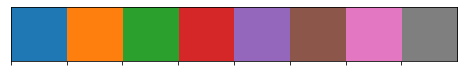

In [12]:
sns.palplot(c_pal_db)

### tSNE space

In [ ]:
clustering.labels_.shape

In [ ]:

clus_all = clustering.labels_
colors_space = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]


fig, axes = plt.subplots(1,1, figsize = (5,5), sharex=True, sharey=True)

axes.scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = colors_space)
axes.set_xlim([-100, 100])
axes.set_ylim([-100, 100])
fig.savefig('../../ciona_tierpsy_behavior/Figures/tsne_results/behavioural_space_rescaled1.png')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (5,5), sharex=True, sharey=True)

axes.scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5)
axes.set_xlim([-100, 100])
axes.set_ylim([-100, 100])
fig.savefig('../../ciona_tierpsy_behavior/Figures/tsne_results/behavioural_space_blue_rescaled1.png')

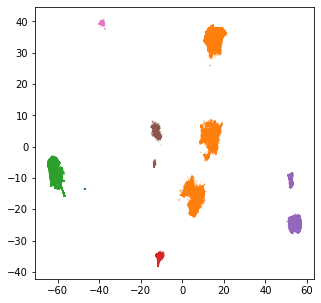

In [15]:

clus_all = clustering.labels_
colors_space = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]


fig, axes = plt.subplots(1,1, figsize = (5,5), sharex=True, sharey=True)

axes.scatter(embedding_test2[:,0], embedding_test2[:,1], s = 0.05, alpha =0.5, c = colors_space)
# axes.set_xlim([-100, 100])
# axes.set_ylim([-100, 100])
# fig.savefig('../../ciona_tierpsy_behavior/Figures/tsne_results/behavioural_space_rescaled1.png')

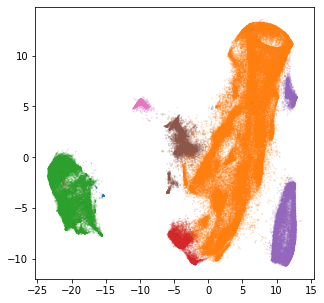

In [16]:

clus_all = clustering.labels_
colors_space = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]


fig, axes = plt.subplots(1,1, figsize = (5,5), sharex=True, sharey=True)

axes.scatter(embedding_test3[:,0], embedding_test3[:,1], s = 0.05, alpha =0.5, c = colors_space)
# axes.set_xlim([-100, 100])
# axes.set_ylim([-100, 100])

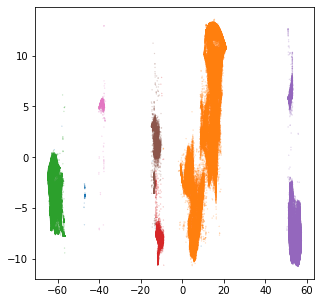

In [17]:
clus_all = clustering.labels_
colors_space = [c_pal_db[label_map_db[clus_all[i]]] for i in range(len(clus_all)) ]


fig, axes = plt.subplots(1,1, figsize = (5,5), sharex=True, sharey=True)

axes.scatter(embedding_test2[:,0], embedding_test3[:,1], s = 0.05, alpha =0.5, c = colors_space)
# axes.set_xlim([-100, 100])
# axes.set_ylim([-100, 100])

### tSNE space plots

In [ ]:

clus_control = df_control_tsne_results['clus_db']
clus_drug = df_drug_tsne_results['clus_db']

colors_drug = [c_pal_db[label_map_db[clus_drug[i]]] for i in range(len(clus_drug)) ]
colors_control = [c_pal_db[label_map_db[clus_control[i]]] for i in range(len(clus_control)) ]

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 5), sharex=True, sharey=True)
axes = axes.ravel()


# axes[0].scatter(embedding_test[:,0], embedding_test[:,1], s = 0.05, alpha =0.5, c = colors_db)
axes[0].scatter(df_control_tsne_results['tsne_proj_0'], df_control_tsne_results['tsne_proj_1'], s = 0.05, alpha =0.5, c = colors_control)
axes[1].scatter(df_drug_tsne_results['tsne_proj_0'], df_drug_tsne_results['tsne_proj_1'], s = 0.05, alpha =0.5, c = colors_drug)
# axes[3].scatter(tsne_light_all[:,0], tsne_light_all[:,1], s = 0.05, alpha =0.5, c = colors_light)

In [ ]:

# df_drug_tsne_results.to_pickle('../Data/tsne_drug_results.pkl')
# df_light_tsne_results.to_pickle('../Data/tsne_light_results.pkl')

In [ ]:
fig.savefig('tsne_proj_results_control_and_drug_datasets.png')

### plots comparison

In [ ]:
df_control_tsne_results= pd.read_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_control_results_clus.pkl')

In [ ]:
df_control_tsne_results['drug'] = 'None'

In [ ]:
df_drug_tsne_results= pd.read_pickle('/share/data/longterm/10/athira/Jan26_preSeminarResults/tsne_drug_results_clus.pkl')

In [ ]:
df_drug_tsne_results.columns

In [ ]:
df_drug_tsne_results['drug'] = df_drug_tsne_results['filename'].apply(lambda x: x.split('_')[4])

In [ ]:
df_drug_tsne_results.head()

In [ ]:
df_control_and_drug_tsne_results = pd.concat([df_control_tsne_results, df_drug_tsne_results])

In [ ]:
df_control_and_drug_tsne_results['active'] = df_control_and_drug_tsne_results['clus_db'].apply(lambda x: True if x !=1 else False) 

In [ ]:
df_control_and_drug_tsne_results_active = df_control_and_drug_tsne_results[df_control_and_drug_tsne_results['clus_db'] != 1]

In [ ]:
df_durations_per_and_cluster = df_control_and_drug_tsne_results.groupby(['drug','clus_db'])['frames'].describe()[['count']]

In [ ]:
df_percents = df_durations_per_and_cluster.groupby(['drug'])[['count']].apply(lambda x:100 * x / (x.sum())).reset_index()

In [ ]:
df_percents

In [ ]:
# df_percents['clus_db'] = df_percents['clus_db'].apply(lambda x: x-1)

In [ ]:
pivoted_df = df_percents.pivot(index = 'drug', columns='clus_db', values = 'count')

In [ ]:
pivoted_df

In [ ]:
pivoted_df.to_csv('../../ciona_tierpsy_behavior/Figures/tsne_results/drugs_stacked_percentage_clusters.csv')

In [ ]:
colors_map = [c_pal_db[label_map_db[i]] for i in [0,1,2,3,4,5] ]

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15,5))
pivoted_df.plot(kind='bar',stacked='True', ax=axes, legend=False, color = ['b','r'])
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right")
# axes.set_xticklabels(drug_order, rotation = 45, ha="right")
axes.set_xlabel('percentage active vs idle')
plt.gcf().subplots_adjust(bottom=0.25)
plt.legend(loc="upper center", bbox_to_anchor=(1.03,1))
# fig.savefig('../../ciona_tierpsy_behavior/Figures/tsne_results/drugs_stacked_AvsI_annot.svg')

for i, p in enumerate(axes.patches):
    if i < 18:
        vert = -10

        axes.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, vert), 
                       textcoords = 'offset points')
        
fig.savefig('../../ciona_tierpsy_behavior/Figures/tsne_results/drugs_stacked_AvsI_annot.svg')

# Finding traces

In [ ]:
# x = clustering.fit_predict(df_wv_filt_in.values)

In [ ]:
# test_labels, strengths = hdbscan.prediction.approximate_predict(clusterer, tsne_in.data)

In [ ]:
# memb_vectors = hdbscan.prediction.membership_vector(clusterer, tsne_in.data)

In [ ]:
# test_labels.max()

In [ ]:
np.unique(test_labels)

In [ ]:
np.unique(test_labels[strengths >= 0.9])

In [ ]:
np.sum(test_labels == -1)

In [ ]:
len(np.unique(test_labels))

In [ ]:
skel_array.shape

In [ ]:
# label_colors

In [ ]:
skel_array.shape

In [ ]:
plt.scatter(skel_array[:,12,0], skel_array[:,12,1], color = label_colors, alpha = 0.7, s = 0.9)
    
# ax.axis("equal")
# ax.set_title(testfile)

In [ ]:
# fig, ax = plt.subplots(figsize = (5,5))

# for i in range(len(skel_array)):

#     ax.plot(skel_array[i,:,0], skel_array[i,:,1], color = c_pal[test_labels[i]], alpha = 0.7)
    
# ax.axis("equal")
# # ax.set_title(testfile)

In [ ]:
fnames_check_3 = ['20180716_134809_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_135432_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_140012_1_5m0s_None_None_None_skeletons.hdf5']

In [ ]:
fnames_check_3_browns = ['20180716_134809_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_135432_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_140012_1_5m0s_None_None_None_skeletons.hdf5']

In [ ]:
fnames_check = [       '20180716_134809_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_154119_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_151220_1_5m0s_None_None_None_INVERTED_skeletons.hdf5',
       '20180716_164934_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_135432_1_5m0s_None_None_None_skeletons.hdf5',
       '20180716_140012_1_5m0s_None_None_None_skeletons.hdf5',
'20180716_134810_1_5m0s_Methiothepin_None_None_skeletons.hdf5',
'20180716_131647_1_5m0s_Serotonin_None_None_INVERTED_skeletons.hdf5']

In [ ]:
fnames_all = list(df_control_and_drug_tsne_results.filename.unique())

In [ ]:
fnames_0716_1 = [fn for fn in fnames_all if fn.startswith('20180716_1')]

In [ ]:
print([fn for fn in fnames_all if fn.startswith('20180823_151523')])

In [ ]:
fnames_brown = ['20180716_164934_1_5m0s_None_None_None_skeletons.hdf5',
                '20180808_123808_1_5m0s_None_None_None_skeletons.hdf5',
                '20180823_151523_1_15m0s_None_None_None_skeletons.hdf5',
               ]

In [ ]:
fnames_0716_1

In [ ]:
df_tsne_results_grouped = df_control_and_drug_tsne_results.groupby('filename')

In [ ]:
# '20180727_115537_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180817_121415_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180808_114234_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180705_123548_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180806_133006_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180808_123808_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180730_103154_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180716_164934_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180725_102308_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180716_151220_1_5m0s_None_None_None_INVERTED_skeletons.hdf5',
#        '20180817_123957_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180709_094858_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180709_114302_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180823_124209_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180823_151523_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180716_154119_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180706_113314_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180716_134809_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180808_115805_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180709_145701_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180718_135348_1_5m0s_None_None_None_INVERTED_skeletons.hdf5',
#        '20180808_160026_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180709_121000_1_5m0s_None_None_None_skeletons.hdf5',
#        '20180727_110004_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180817_101417_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180803_164739_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180823_124233_1_15m0s_None_None_None_skeletons.hdf5',
#        '20180716_135432_1_5m0s_None_None_None_skeletons.hdf5',
pink_fnames = [
       '20180817_103936_1_5m0s_None_None_None_skeletons.hdf5',
       '20180822_153525_1_15m0s_None_None_None_skeletons.hdf5',
       '20180823_125825_1_5m0s_None_None_None_skeletons.hdf5',
       '20180807_190944_1_15m0s_None_None_None_skeletons.hdf5',
       '20180706_102015_1_5m0s_None_None_None_skeletons.hdf5',
       '20180709_163004_1_15m0s_None_None_None_skeletons.hdf5',
       '20180727_133018_1_15m0s_None_None_None_skeletons.hdf5',
       '20180725_114241_1_15m0s_None_None_None_skeletons.hdf5']

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (20,10), sharex=True, sharey=True)
axes = axes.ravel()
for i, fname in enumerate(pink_fnames):
    
    skel_file = os.path.join(skel_files_path,fname)
    skel_array = read_skeleton_as_array(skel_file)
    skel_array = del_nan_rows(skel_array)
    
    axes[i].scatter(skel_array[:,12,0], skel_array[:,12,1], alpha = 0.7, s = 0.9)
    axes[i].set_title('_'.join(fname.split('_')[:2]))
    print(fname)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15,5), sharex=True, sharey=True)
axes = axes.ravel()
for i, fname in enumerate(random.sample(list(fnames_brown), 3)):
    
    skel_files_path = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'
    skel_file = os.path.join(skel_files_path,fname)
    skel_array = read_skeleton_as_array(skel_file)
    
    
    df = df_tsne_results_grouped.get_group(fname)
    df_clus = df['clus_db']
    col_file = [c_pal_db[label_map_db[i]] for i in df['clus_db'] ]
    
    try:
        skel_array_ = del_nan_rows(skel_array)
        axes[i].scatter(skel_array_[:,12,0], skel_array_[:,12,1], alpha = 0.7, s = 0.9, c= col_file)
    except ValueError:
        
        print('some bad frames')
        skel_array_ = skel_array[list(df.frames)]
        axes[i].scatter(skel_array_[:,12,0], skel_array_[:,12,1], alpha = 0.7, s = 0.9, c= col_file)
    finally:
        axes[i].set_title('_'.join(fname.split('_')[:5]))
        print(fname, skel_array.shape[0])

In [ ]:
fig.savefig('browns_traces.png')

In [ ]:
fnames_pink =  df_control_and_drug_tsne_results[((df_control_and_drug_tsne_results['clus_db'] == 5))]['filename'].unique()

In [ ]:
len(fnames_pink)

In [ ]:
fnames_check_3

In [ ]:
fnames_pink = list(fnames_pink)

In [ ]:
fnames_pink.remove(fnames_check_3[2])

In [ ]:
len(fnames_pink)

In [ ]:
df_pink_minus3_list = []
for fn in fnames_pink:
    df_pink_minus3_list.append(df_tsne_results_grouped.get_group(fn))
df_pink_minus3 = pd.concat(df_pink_minus3_list)

In [ ]:
df_pink_minus3_active = df_pink_minus3[df_pink_minus3['clus_db'] != 1]
df_pink_minus3_active

In [ ]:
df_durations_per_and_pink = df_pink_minus3_active.groupby(['drug','clus_db'])['frames'].describe()[['count']]
df_durations_per_and_pink[['count']] = df_durations_per_and_pink[['count']].astype(int)

In [ ]:
df_percents_active_pink = df_durations_per_and_pink.groupby(['drug'])[['count']].apply(lambda x:100 * x / (x.sum())).reset_index()

In [ ]:
df_percents_active_pink

In [ ]:
df_durations_per_and_pink.reset_index(inplace=True)

In [ ]:
df_pivoted_pink = df_durations_per_and_pink.pivot(index = 'drug', columns='clus_db', values = 'count')

In [ ]:
df_pivoted_pink_percent = df_percents_active_pink.pivot(index = 'drug', columns='clus_db', values = 'count')

In [ ]:
df_pivoted_pink_percent

In [ ]:
colors_map

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(12,10))
df_pivoted_pink_percent[5].plot(kind='bar', ax=axes, legend=False, color = colors_map[4])
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right")
# axes.set_xticklabels(drug_order, rotation = 45, ha="right")
axes.set_ylabel('Percent of frames classified as pink cluster ')
axes.set_title(f'Excluding the 3 files on the same date, \n  Out of 694 control and 899 drug experiments')
plt.gcf().subplots_adjust(bottom=0.25)
plt.legend(loc="upper center", bbox_to_anchor=(1.03,1))

fig.savefig('percentage_pink_occurences_in_other_experiments.png')

In [ ]:
fnames_serotonin_pink

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (20,10), sharex=True, sharey=True)
axes = axes.ravel()
for i, fname in enumerate(random.sample(fnames, 8)):
    
    skel_file = os.path.join(skel_files_path,fname)
    skel_array = read_skeleton_as_array(skel_file)
    skel_array = del_nan_rows(skel_array)
    
    axes[i].scatter(skel_array[:,12,0], skel_array[:,12,1], alpha = 0.7, s = 0.9)
    axes[i].set_title('_'.join(fname.split('_')[:2]))
    print(fname)

In [ ]:
fnames = ['20180817_123456_1_5m0s_None_None_None_skeletons.hdf5',
'20180817_144212_1_5m0s_None_None_None_skeletons.hdf5',
'20180926_102013_1_5m0s_None_None_None_INVERTED_skeletons.hdf5',
'20180730_103154_1_15m0s_None_None_None_skeletons.hdf5',
'20180730_131522_1_5m0s_None_None_None_skeletons.hdf5',
'20180727_112021_1_5m0s_None_None_None_skeletons.hdf5',
         '20180706_102015_1_5m0s_None_None_None_skeletons.hdf5',
       '20180709_163004_1_15m0s_None_None_None_skeletons.hdf5',
       '20180727_133018_1_15m0s_None_None_None_skeletons.hdf5',
       '20180725_114241_1_15m0s_None_None_None_skeletons.hdf5']

# Sampling using histogram: tests

In [ ]:
def nearest_neighbours(test_val, lst):
    for i, l in enumerate(zip(lst, islice(lst, 1, None))):
        l1 = l[0]
        l2 = l[1]
        if l1 <= test_val <= l2:
#             return l1, l2, i, 1 / x_hist[i]
            return 1/x_hist[i]

In [ ]:
def closest(test_val, lst): 
    
    lst = np.asarray(lst) 
    idx = ((lst - test_val)).argmin() 
    return (1/x_hist[idx-1]) 


def largest_within_delta(k, lst):
    X = np.asarray(lst)
    right_idx = X.searchsorted(k,'left')
#     if (k - X[right_idx]) <= delta:
    
    return (1/x_hist[right_idx])
    
    

In [ ]:
x_hist, x_ed = np.histogram(df_all_117['speed_neck'], bins =100,  density =1)

In [ ]:
test_ind = random.choice(range(len(df_all_117.index)))
test_speed = df_all_117['speed_neck'].values[test_ind]
print(test_ind, test_speed)
nn_result = nearest_neighbours(test_speed, x_ed) 
closest_result = largest_within_delta(test_speed, x_ed) 
print(nn_result, closest_result)
nn_result == closest_result

In [ ]:
X = list(df_all_117['speed_neck'].values)
ind = np.searchsorted(x_ed, X, 'right')
ind = list(ind - 2)
weights = [x_hist[i] for i in ind]

In [ ]:
feat_weights_df['speed_neck']

In [ ]:
# for key, coeff in tqdm.tqdm(feat_coeff_dict.items()):
    
#     x_hist, x_ed = np.histogram(df_all_117[key], bins =100,  density =1)
#     weights_test = df_speeds.apply(lambda x: largest_within_delta(x, x_ed), axis =1,  result_type='expand')
#     feat_weights_dict[key] = list(weights_test)
     

In [ ]:
weights_test

In [ ]:
feat_weights_df.replace(np.inf, 0, inplace=True)

In [ ]:
weights_test = feat_weights_df.sum(axis=1)

In [ ]:
# weights_test = df_all_117.apply(lambda y: nearest_neighbours(y['speed_neck'], x_ed), axis =1,  result_type='expand')

In [ ]:
df_samples = df_all_117.sample(n = 20000, weights = feat_weights_df['speed_neck'])
df_samples['speed_neck'].hist(bins=100)

# Sampling using multiple speed values

In [ ]:
def closest(K, lst, feat_hist, coeff): 
    
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return (1/feat_hist[idx-1]) 

In [ ]:
def nearest_neighbours_feat(test_val, lst, feat_hist, coeff):
    
    for i, l in enumerate(zip(lst, islice(lst, 1, None))):
        l1 = l[0]
        l2 = l[1]
        if l1 <= test_val <= l2:
            return (1/feat_hist[i])

In [ ]:
# for key, coeff in feat_coeff_dict.items():
    
#     x_hist, x_ed = np.histogram(df_all_117[key], bins =100,  density =1)
#     weights_test = df_all_117.apply(lambda y: nearest_neighbours_feat(y[key]/df_all_117[key].max(), x_ed, x_hist, coeff), axis =1,  result_type='expand')
#     feat_weights_dict[key] = list(weights_test)
    

In [ ]:
# open('/share/data/temp/athira/WaveletsTSNE/TSNE_embedding_all.tsne', 'wb')

In [ ]:
feat_weights_df

In [ ]:
for key, coeff in feat_coeff_dict.items():
    
    max_key = feat_weights_df[key].max()
    feat_weights_df[key] = feat_weights_df[key]/max_key

In [ ]:
feat_weights_df['final_weights'] = feat_weights_df.apply(lambda y: np.sum([y[key] * coeff for key, coeff in feat_coeff_dict.items()]), axis =1,  result_type='expand')

In [ ]:
for key, coeff in feat_coeff_dict.items():
    
    max_key = feat_weights_df[feat_weights_df[key] != np.inf][key].max()
    feat_weights_df[key].replace(np.inf,max_key, inplace=True)
   

In [ ]:
feat_weights_df['final_weights'] = feat_weights_df.sum(axis=1) 

In [ ]:
feat_weights_df['final_weights']

In [ ]:
df_all_117['speed_neck'].hist(bins=100)

In [ ]:
feat_weights_df['speed_neck'].hist(bins=100)

In [ ]:
df_samples = df_all_117.sample(n = 20000, weights = feat_weights_df['speed_neck'])
df_samples['speed_neck'].hist(bins=100)

In [ ]:
df_samples['speed_tail_tip'].hist(bins=100)

# Random tests

## Trials to sample

In [ ]:
# x  = df_all_117.speed_neck.hist(bins = 100, density =1)

In [ ]:
x_hist, x_ed = np.histogram(df_all_117['speed_neck'], bins =100,  density =1)

In [ ]:
# bound = np.max(x) + np.min(x)

In [ ]:
from itertools import islice

def nearest_neighbours(test_val, lst):
    for i, l in enumerate(zip(lst, islice(lst, 1, None))):
        l1 = l[0]
        l2 = l[1]
        if l1 <= test_val <= l2:
#             return l1, l2, i, 1 / x_hist[i]
            return 1/x_hist[i]
#         else :
#             return 1/x_hist[-1]

In [ ]:
test_ind = random.choice(range(len(df_all_117.index)))
test_speed = df_all_117['speed_neck'].values[test_ind]
print(test_ind, test_speed)


In [ ]:

print(test_ind, test_speed)
nearest_neighbours(test_speed, x_ed)

In [ ]:

# print(test_ind, test_speed)
# nearest_neighbours_feat(test_speed, x_ed, x_hist, 0.5)

In [ ]:
x_hist

In [ ]:
weights_test = df_all_117.apply(lambda y: nearest_neighbours(y['speed_neck'], x_ed), axis =1,  result_type='expand')

In [ ]:
weights_test.shape

In [ ]:
len(list(weights_test))

In [ ]:
df_samples = df_all_117.sample(n = 10000, weights = weights_test)
df_samples['speed_neck'].hist(bins=100)

In [ ]:
df_samples2 = df_all_117.sample(n = 20000, weights = weights_test)
df_samples2['speed_neck'].hist(bins=100)

In [ ]:
# len(df_samples['filename'].unique())

In [ ]:
# pd.DataFrame(s_tsne)

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes = axes.ravel()
axes[0].scatter(df_samples2['tsne_0'], df_samples2['tsne_1'], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(df_samples2['tsne_0'], df_samples2['tsne_1'], s = 0.05, alpha =0.5, c = df_samples2['speed_neck'], cmap = 'jet')

## Test individual files

In [ ]:
i = 71

X_in = X_data[y_ciona == i]
df_in = df_files.get_group(fnames[i])

In [ ]:
X_in.shape

In [ ]:
tsne_in = test_tsne.transform(X_in)

In [ ]:
tsne_in.shape

In [ ]:
sum_to_ann_in = tsne_in.sum(axis=1)

In [ ]:
sum_speed_in = df_in['speed_neck'] + df_in['speed_tail_mid'] + df_in['speed_tail_tip'] + \
                df_in['speed_tail_base'] + df_in['speed_tail_pre_mid'] + df_in['speed_tail_post_mid'] 

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = range(tsne_in.shape[0]), cmap = 'jet')
axes[1].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = sum_speed_in, cmap = 'jet')
axes[2].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = sum_to_ann_in, cmap = 'jet')

axes[3].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_in['speed_neck'], cmap = 'jet')
axes[4].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_in['speed_tail_mid'], cmap = 'jet')
axes[5].scatter(tsne_in[:,0], tsne_in[:,1], s = 0.05, alpha =0.5, c = df_in['speed_tail_tip'], cmap = 'jet')

In [ ]:
sys.path.append("../Code/")

# Import functions for handling skeleton files
from data_handling import read_skeleton_as_array, calc_quality, del_nan_rows

In [ ]:
skel_path = f'/share/data/temp/athira/Tierpsy_skeleton_files_July13/{fnames[i]}'
skel_array = del_nan_rows(read_skeleton_as_array(skel_path))

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
axes = axes.ravel()
axes[0].scatter(skel_array[:,12,0], skel_array[:,12,1],s = 0.5, alpha =0.5, c = sum_speed_in, cmap='jet')
axes[1].scatter(skel_array[:,12,0], skel_array[:,12,1],s = 0.5, alpha =0.5, c = range(tsne_in.shape[0]), cmap='jet')
# axes[1].plot(skel_array[0:5000,12,0], skel_array[0:5000,12,1])
# axes[2].plot(skel_array[5000:10000,12,0], skel_array[5000:10000,12,1])
# axes[3].plot(skel_array[10000:15000,12,0], skel_array[10000:15000,12,1])
# axes[4].plot(skel_array[15000:20000,12,0], skel_array[15000:20000,12,1])
# axes[5].plot(skel_array[20000:,12,0], skel_array[20000:,12,1])